# 3.2. Friction Distribution between twisted Spiral Torus

前の章で螺旋トーラスと球体の接触位置と荷重は確認できたので，次のステップはクーロン摩擦の分布を調べる．なお，この章では螺旋トーラスは剛体として扱う．接触部のみ弾性体である．

## 3.2.1. 摩擦モデルの比較

|                      |      US     |     JP    |
|:--------------------:|:-----------:|:---------:|
|    Representative    | S2A, Timken |  NSK, NTN |
|     Totalization     | Integration $ \int $ ![Asset1](Asset1.svg)| Summation $ \sum $ ![Asset2](Asset2.svg)|
| contact condition |  ellipse       |   line (approximate)     |
| friction coefficient | Simple Coulomb <br> ![Coulomb](Coulomb.jpg)| Smooth Coulomb　<br> ![Smooth_Coulomb](Smooth_Coulomb.jpg)  |
|         Merit        |             |           |

In [1]:
%config InlineBackend.figure_format = "svg"


In [2]:
import numpy as np
from matplotlib import pyplot as plt


In [3]:
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


直交座標系で圧力分布を調べる．

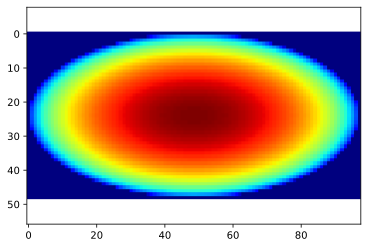

In [4]:
n = 49
x = np.linspace(-1.0, 1.0, 2 * n)
y = np.linspace(-1.0, 1.0, n)
x_, y_ = np.meshgrid(x, y)
Psq = 1.0 - np.square(x_) - np.square(y_)
Psq[Psq<0.0] = 0.0
P = np.sqrt(Psq)

plt.imshow(P, cmap=plt.cm.jet)
plt.axis('equal')
plt.show()


![NTN1](NTN1.jpg)
![NTN2](NTN2.jpg)

99x99のメッシュの総和と，NTNが提唱している式とを比較する．


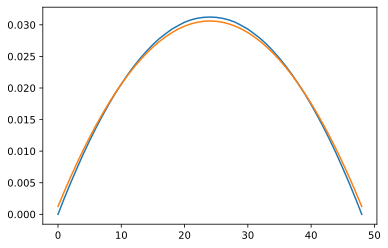

In [5]:
SFR = TB.SliceForceRatio(n)

plt.plot(P.sum(1) / P.sum())
plt.plot(SFR)


直交座標系では，接触していない場所にもメッシュが存在してしまうため非効率である．そのため，極座標系へ置き換える．

$$
P(x, y) = P_{\text{max}} \sqrt{1 - \frac{x^2}{a^2} - \frac{y^2}{b^2}}
$$
_
$$
\left( -a \leq x \leq a, -b \leq y \leq b \right)
$$
_
$$
x = ar \cos{\theta}, y = br \sin{\theta}
$$
_
$$
\left( 0 \leq r \leq 1, 0 \leq \theta \leq 2\pi \right)
$$
_
$$
P(r, \theta) = P_{\text{max}} \sqrt{1 - r^2}
$$


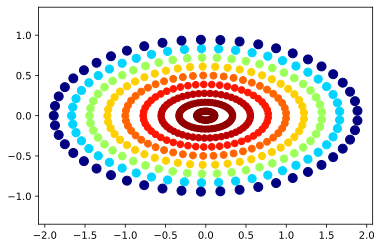

In [6]:
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)
x_ = r_ * np.cos(t_) * 2.0 # = a 
y_ = r_ * np.sin(t_) * 1.0 # = b
F_ = np.sqrt(1 - np.square(r_))

plt.scatter(x_, y_, c=F_, cmap=plt.cm.jet, s=100*(1-F_*0.6))
plt.axis('equal')
plt.show()


$$
\begin{eqnarray*}
\text{d} F &=& P \cdot \text{d} S \\
&=& P(r, \theta) \cdot ab \cdot r \text{d} \theta \text{d} r \\
&=& P_{\text{max}} ab \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\
&=& \frac{3F}{2 \pi} \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\
\int^{\theta_1}_{\theta_0} \int^{r_1}_{r_0} \text{d} F &=& \frac{3F}{2 \pi}(\theta_1 - \theta_0) \int^{r_1}_{r_0} r \sqrt{1 - r^2} \text{d} r \\
&=& \frac{3F}{2 \pi}(\theta_1 - \theta_0) \left[ -\frac{1}{3} (1 - x^2)^{1.5} \right]^{r_1}_{r_0} \\
\end{eqnarray*}
$$


In [7]:
dt = t[1] - t[0]
r_node = np.linspace(0., 1., int(n/5+1))
Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

r_, t_ = np.meshgrid(r, t)
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio.sum()

1.0

## 3.2.2. 動解析を使って摩擦の釣り合いを観察する

まずはパラメタの設定．


In [8]:
R = 6.35 / 2
Rg = R * 1.08
dR = R * 0.08 / np.sqrt(2)
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dR, -dR],[-dR, dR]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dR, -dR],[dR, dR]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10

n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi
r_, t_ = np.meshgrid(r, t)
r_mesh = r_.reshape(-1)
t_mesh = t_.reshape(-1)
dr = r[1] - r[0]
dt = t[1] - t[0]
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio_mesh = ratio.reshape(-1)
x_mesh = r_mesh * np.cos(t_mesh)
y_mesh = r_mesh * np.sin(t_mesh)


$$
\frac{\text{d}}{\text{d}t}\begin{pmatrix} x \\ v \\ \omega \end{pmatrix} 
= \begin{pmatrix} v \\ F/m \\ T/I \end{pmatrix}
$$

$$
\begin{eqnarray*}
u_* &=& v_* + \omega_* \times (p - x_*) \\
\Delta u &=& u_{\text{groove}} - u_{\text{ball}} \\
\end{eqnarray*}
$$

$$
\begin{eqnarray*}
F &=& \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left( Hertzian  + \int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \mu \text{d}F \right) \\
T &=& \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left(\int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \times R \cdot \mu \text{d}F \right)
\end{eqnarray*}
$$


In [9]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, x_mesh, y_mesh, ratio_mesh, mu, Ball_m, Ball_I):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        
        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = BL_v[iSP,i,:,:] - SP_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = - F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])


In [10]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -10 * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


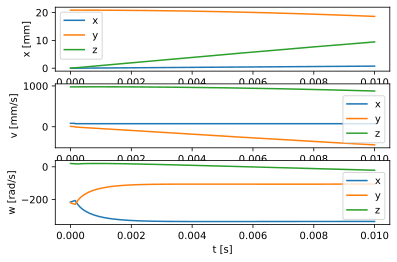

In [11]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, x_mesh, y_mesh, ratio_mesh, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()


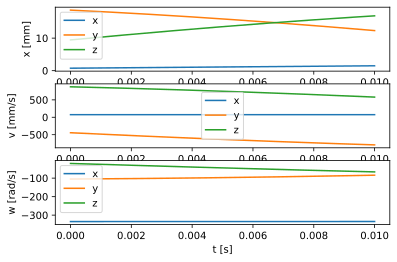

In [12]:
xvw_ball = sol[-1, :]

sol_check = odeint(vFmTI_ball, xvw_ball, t, args=(R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, x_mesh, y_mesh, ratio_mesh, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol_check[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol_check[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol_check[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()

## 3.2.3. 定常状態の確認

各パラメタを詳らかに観察する．


In [13]:
def get_dv(xvw_ball):
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]

    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)

    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()

    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()

    eta   = np.zeros([2, 3])
    b_dir = eta.copy()

    xyz2eta = np.zeros([2, 3, 3])

    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])

    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()

    for iSP, SP in enumerate(SP12):

        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = np.cross(b_dir[iSP,:], exyz[iSP,i,:])

                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]

                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh

                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = BL_v[iSP,i,:,:] - SP_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = - F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)

    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    return a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv


In [14]:
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit): 
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(18, 6))

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax


### 3.2.3.1. Start Condition (Artificial setting)


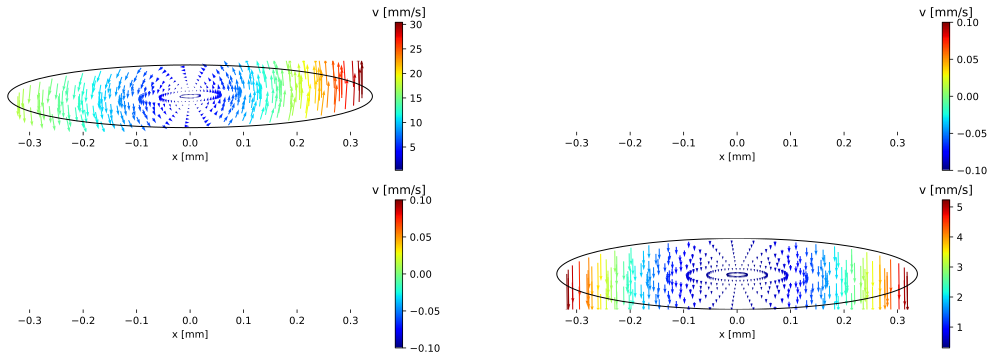

In [26]:
a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv = get_dv(xvw_ball = sol[0, :])
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, -dv, 'v [mm/s]')


### 3.2.3.2. Right before the collision


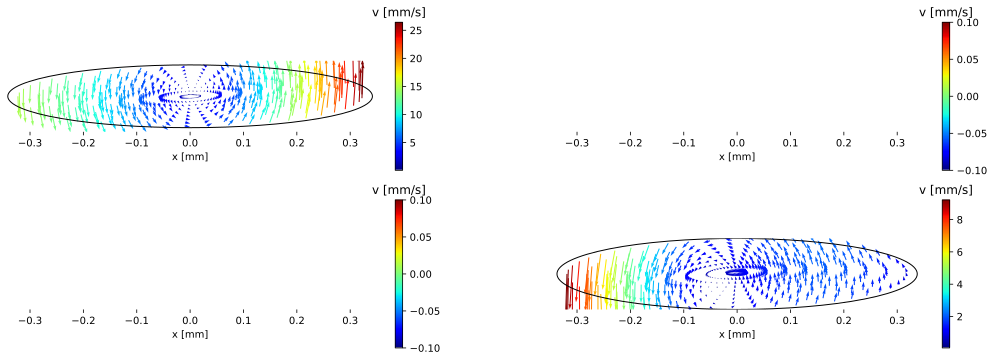

In [27]:
a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv = get_dv(xvw_ball = sol[15, :])
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, -dv, 'v [mm/s]')


### 3.2.3.3. Right after the collision


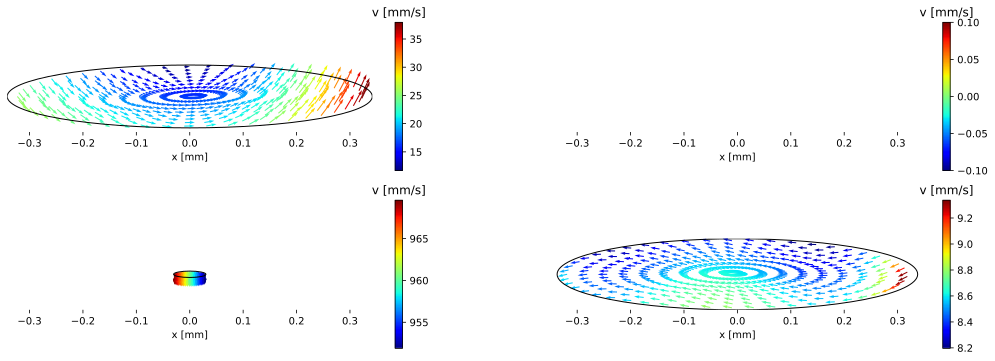

In [28]:
a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv = get_dv(xvw_ball = sol[20, :])
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, -dv, 'v [mm/s]')


### 3.2.3.4 Steady State


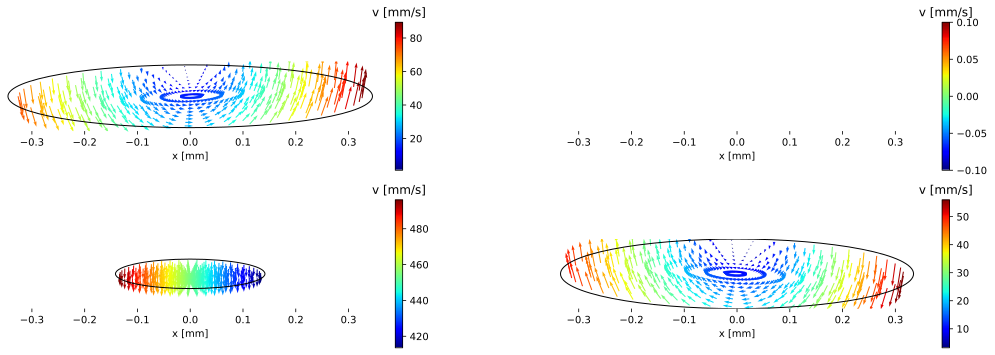

In [29]:
a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv = get_dv(xvw_ball = sol[-1, :])
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, -dv, 'v [mm/s]')


In [19]:
xvw_ball = sol[-1, :]
x_ball = xvw_ball[0:3]
v_ball = xvw_ball[3:6]
w_ball = xvw_ball[6:9]

Zeros = np.zeros(3)
vr = np.linalg.norm(v_ball)
x_square = np.square(x_mesh)
y_square = np.square(y_mesh)

dx      = np.zeros([2, 2])
k_      = dx.copy()
a_      = dx.copy()
b_      = dx.copy()
v_      = dx.copy()
F_norm  = dx.copy()

cos_sin   = np.zeros([2, 2, 2])
SP_r_inv  = cos_sin.copy()
R_Reduced = cos_sin.copy()

exyz    = np.zeros([2, 2, 3])
F_      = exyz.copy()
a_dir   = exyz.copy()
peak    = exyz.copy()

eta   = np.zeros([2, 3])
b_dir = eta.copy()

xyz2eta = np.zeros([2, 3, 3])

n_mesh = len(x_mesh)
F_mesh = np.zeros([2, 2, n_mesh])

p_mesh = np.zeros([2, 2, n_mesh, 3])
SP_v   = p_mesh.copy()
BL_v   = p_mesh.copy()
dv     = p_mesh.copy()
muT    = p_mesh.copy()

v_dir = np.zeros([2, 2, 3, n_mesh])
muF   = v_dir.copy()

for iSP, SP in enumerate(SP12):

    eta[iSP,:] = SP.to_eta2(x_ball)
    xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
    b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])

    for i in range(2):
        cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
        if dx[iSP,i] > 0:
            SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
            R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
            k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
            v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
            F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
            F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

            a_dir[iSP,i,:] = np.cross(b_dir[iSP,:], exyz[iSP,i,:])

            peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]

            p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
            F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh

            SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
            BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
            dv[iSP,i,:,:]    = BL_v[iSP,i,:,:] - SP_v[iSP,i,:,:]
            v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
            muF[iSP,i,:,:] = - F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
            muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)

Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6


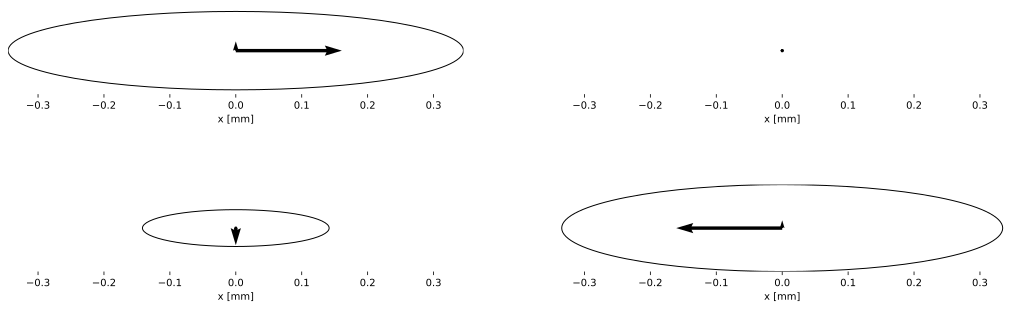

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0  2.329601  0.204453  52.095296
1   0   1  0.000000  0.000000   0.000000
2   1   0 -0.008739 -0.375961   3.760807
3   1   1 -2.328381  0.170758  51.687008


In [25]:
import pandas as pd
muF_table = pd.DataFrame(columns=['S/N', 'L/R', 'muFx [N]', 'muFy [N]', 'Fz [N]'])

# Defining subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 6))

# Creating plot
a_max = a_.max()
b_max = b_.max()

for iSP in range(2):
    for i in range(2):
        a_mesh00 = a_[iSP,i] * x_mesh
        b_mesh00 = b_[iSP,i] * y_mesh

        muFx_sum = np.array([muF[iSP,i,:,:].T.dot(a_dir[iSP,i,:]).sum(), 0.0])
        muFy_sum = np.array([0.0, muF[iSP,i,:,:].T.dot(b_dir[iSP,:]).sum()])
        muF_table = muF_table.append({'S/N':str(iSP), 'L/R':str(i), 'muFx [N]':(muFx_sum + muFy_sum)[0], 'muFy [N]':(muFx_sum + muFy_sum)[1], 'Fz [N]':F_norm[iSP,i]}, ignore_index=True)

        ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
        quiver = ax[iSP, i].quiver([0.0, 0.0], [0.0, 0.0], muFx_sum, muFy_sum, scale=1e1)
        
        ax[iSP, i].add_patch(ellipse)
        ax[iSP, i].set_aspect('equal')
        ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
        ax[iSP, i].spines['right'].set_visible(False)
        ax[iSP, i].spines['top'].set_visible(False)
        ax[iSP, i].spines['left'].set_visible(False)
        ax[iSP, i].spines['bottom'].set_visible(False)
        ax[iSP, i].yaxis.set_ticks([])
        ax[iSP, i].set_xlabel('x [mm]')

plt.show()

print(muF_table)

予想通りだったこと
- 進行方向で，3点目は純粋に進行方向に滑っている．
- 進行方向で，1,2点目の摩擦の和と3点目の摩擦は打ち消し合う．
- 壁面方向で，1,2点目の摩擦の和が3点目の垂直抗力に釣り合う．

納得いかないこと
- 1,2点目の摩擦がほぼ同じ大きさとなっている．
- 1,2点目の摩擦の総和でみた摩擦係数は$\mu$は，入力の0.10より小さい0.05になっている．
